In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("data/return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d

,Nifty_50_1d_return,Dow_Jons_1d_return,S&P_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,sgx_1d_return,indiavix_1d_return
Date,,,,,,,,,,,
07-03-08,-3.590735,-9.741968,-6.772673,-5.787501,-0.827670,-2.292175,-1.613607,-2.858730,1.506145,-4.274937,-0.870647
10-03-08,-1.198291,-0.562125,-0.488627,-0.265148,1.388035,-0.293282,-0.833349,0.152018,-0.910562,-1.000000,7.526045
12-03-08,-0.908122,-1.107938,-1.242273,-1.132312,-0.073911,-1.683766,0.065043,0.414945,-4.022455,-0.892878,-3.989905
13-03-08,-41.669658,-1.765236,-1.569938,-2.669030,0.233156,-1.465969,1.921006,-1.743428,-0.620439,-17.270544,-6.479558
14-03-08,-1.518377,-6.467083,-5.053751,-3.567089,-2.042657,-3.183715,-0.568907,-1.336707,0.248094,-1.602498,-2.609305
...,...,...,...,...,...,...,...,...,...,...,...
29-03-23,-4.801728,-9.557403,-10.046178,-5.001279,-1.693416,-0.945003,-1.311808,-0.591010,-1.490420,-3.567208,3.365632
31-03-23,1.146847,0.704188,0.421222,0.382088,-5.046026,-36.978140,-1.461793,0.261633,-1.617771,0.322594,-0.478895
03-04-23,-0.864952,-0.422278,-0.817199,-1.107129,2.398409,-0.092796,4.130329,-2.322361,2.234979,-1.084189,-0.467526


In [3]:
'''
# Add lagged returns as features
return_1d['Nifty_50_1d_return'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d['Dow_Jons_1d_return_lag1'] = return_1d['Dow_Jons_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_50_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_50_1d_return'] * return_1d['Dow_Jons_1d_return_lag1']'''
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_50_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_50_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_50_1d_return'] >= lower_bound) & (return_1d['Nifty_50_1d_return'] <= upper_bound)]
np.random.seed(42)

In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  S&P_500_1d_return  \
Date                                                                  
07-03-08           -3.590735           -9.741968          -6.772673   
10-03-08           -1.198291           -0.562125          -0.488627   
12-03-08           -0.908122           -1.107938          -1.242273   
14-03-08           -1.518377           -6.467083          -5.053751   
17-03-08           -2.934951           -1.110479          -0.568947   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
07-03-08         -5.787501        -0.827670           -2.292175   
10-03-08         -0.265148         1.388035           -0.293282   
12-03-08         -1.132312        -0.073911           -1.683766   
14-03-08         -3.567089        -2.042657           -3.183715   
17-03-08         -0.289913         2.362785           -0.021818   

          Gold_1d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  S&P_500_1d_return  \
count         2759.000000         2759.000000        2759.000000   
mean            -0.869200           -2.247740          -0.280548   
std              1.428364          111.415248          39.058346   
min             -4.827651        -3692.472716        -556.227168   
25%             -1.608400           -2.004966          -2.041152   
50%             -0.897741           -1.044363          -1.047200   
75%             -0.126608           -0.041719          -0.058169   
max              3.109739         3319.017885        1127.635413   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       2759.000000      2759.000000         2759.000000     2759.000000   
mean          -2.587796        -1.641259           -1.054685       -0.878013   
std           43.040503        21.582184            5.763578       13.855417   
min        -1514.635464      -426.0

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_50_1d_return'].sort_values())
nifty_corr_1d

,Nifty_50_1d_return
S&P_500_1d_return,-0.031009
BOND_10Y_1d_return,-0.026915
Gold_1d_return,-0.019894
Inr_Usd_1d_return,-0.011836
Dow_Jons_1d_return,-0.008213
BRENT_1d_return,-0.006806
Dollar_Index_1d_return,-0.003851
NASDAQ_1d_return,0.012925
indiavix_1d_return,0.015090
sgx_1d_return,0.163692


<Axes: >

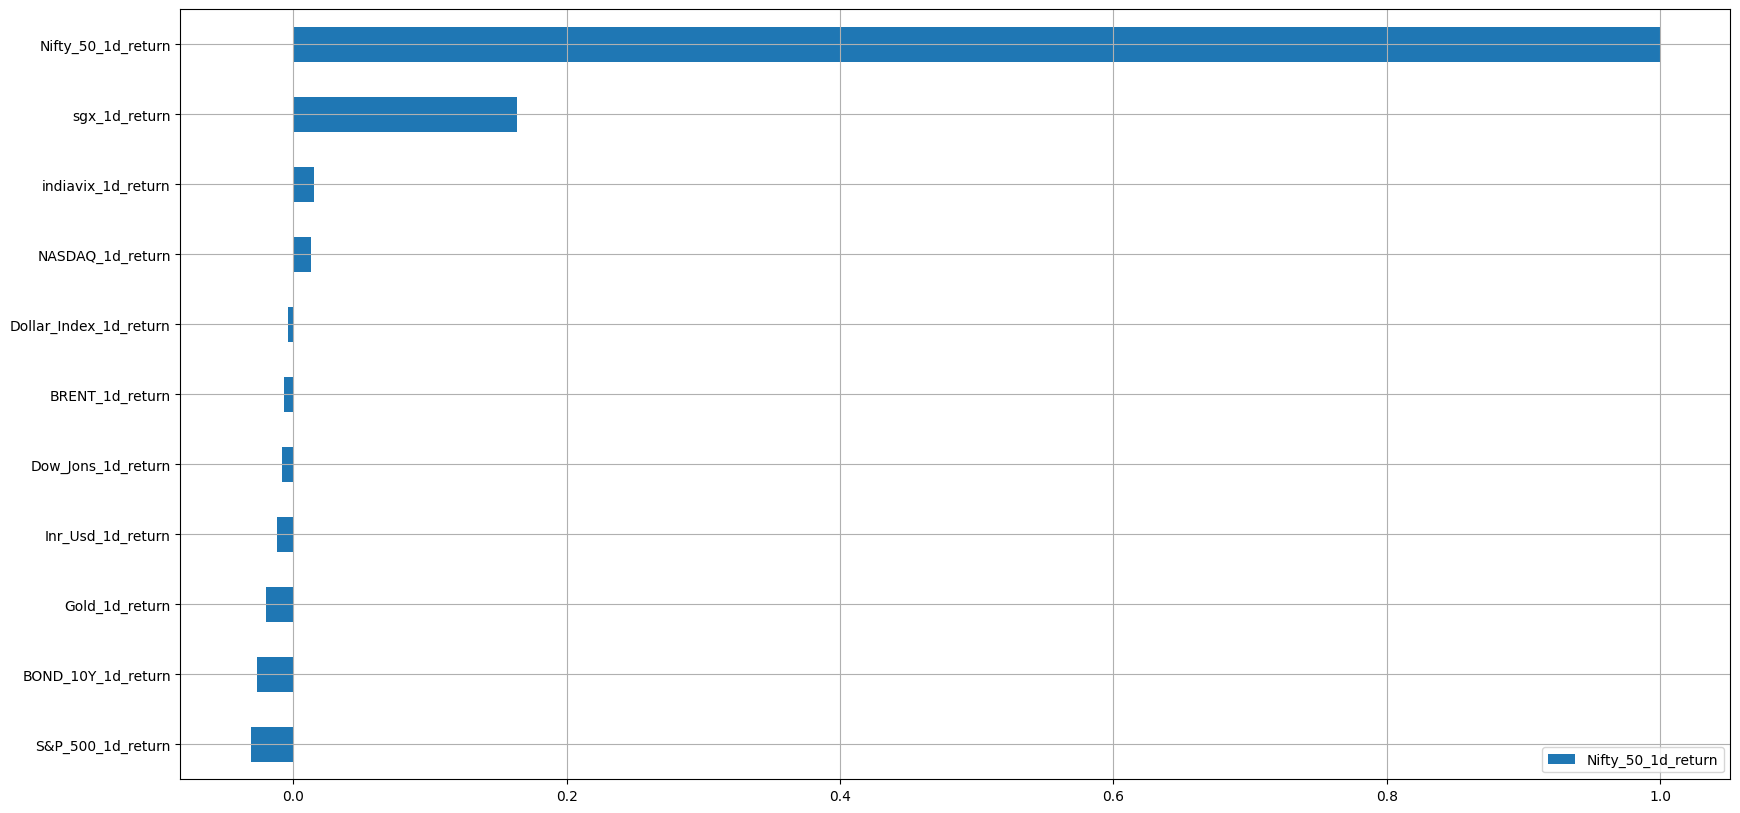

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1d.drop(columns='Nifty_50_1d_return')
y = return_1d['Nifty_50_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Dow_Jons_1d_return', 'S&P_500_1d_return', 'NASDAQ_1d_return',
       'BRENT_1d_return', 'BOND_10Y_1d_return', 'Gold_1d_return',
       'Inr_Usd_1d_return', 'Dollar_Index_1d_return', 'sgx_1d_return',
       'indiavix_1d_return'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_50_1d_return')
y = return_1d['Nifty_50_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 9.46592964e-03 -4.28938831e-02  5.92446425e-02  3.72505893e-02
   4.99298153e-02 -5.81562120e-02 -4.92866993e-02  2.04295909e-01
  -1.95735783e-01 -1.32278298e-01]
 [-6.56192787e-02 -2.50072047e-01 -5.60848611e-02 -2.41707118e-03
   1.90336132e-02 -3.13143887e-02  4.08017206e-02 -4.32428377e-02
  -2.14266208e-01  2.62378290e-01]
 [ 2.64996266e-02  1.79704810e-02  6.90145720e-02 -1.57786785e-01
  -6.23396925e+00 -4.21413190e-02  7.74986182e-02 -5.79159838e-02
   1.00280242e-01  1.06006241e-02]
 [ 1.63872780e-02 -1.37422271e-02  3.44079586e-02  1.87209984e-01
   1.66921143e-01  3.61537290e-01 -3.37138863e-02  3.85991031e-01
  -1.34783513e-02  1.13451486e-02]
 [ 1.10055120e-02 -2.94992935e-02  2.57287684e-02  1.30064441e-01
   8.22313421e-03 -2.60433966e-02  1.24613680e-01  2.76982160e-02
   4.77316302e-02  2.13204013e-01]]
Date
28-03-23   -1.834439
29-03-23   -4.801727
31-03-23    1.146847
03-04-23   -0.864953
06-04-23   -0.737620
Name: Nifty_50_1d_return, dtype: float32


Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 1.0343
R2: 0.4857

For RFR:
MSE: 0.9296
R2: 0.5377

For ETR:
MSE: 0.9985
R2: 0.5035

For GBR:
MSE: 0.8801
R2: 0.5623

For XGBR:
MSE: 1.0944
R2: 0.4558



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is GBR with an MSE of 0.8801.


GradientBoostingRegressor(n_estimators=50, random_state=2)

The best model is XGBR with an MSE of 0.0285.

In [16]:
y_pred = gbr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
10-05-10,-3.446379,-2.398418
31-07-15,1.362211,1.221386
08-10-21,-0.279535,-0.304222
29-01-21,0.233314,-0.322612
18-03-11,0.144397,0.709341
...,...,...
21-10-08,1.277828,-0.178225
03-02-10,-2.482989,-2.088659
27-11-17,-0.793152,-0.921950


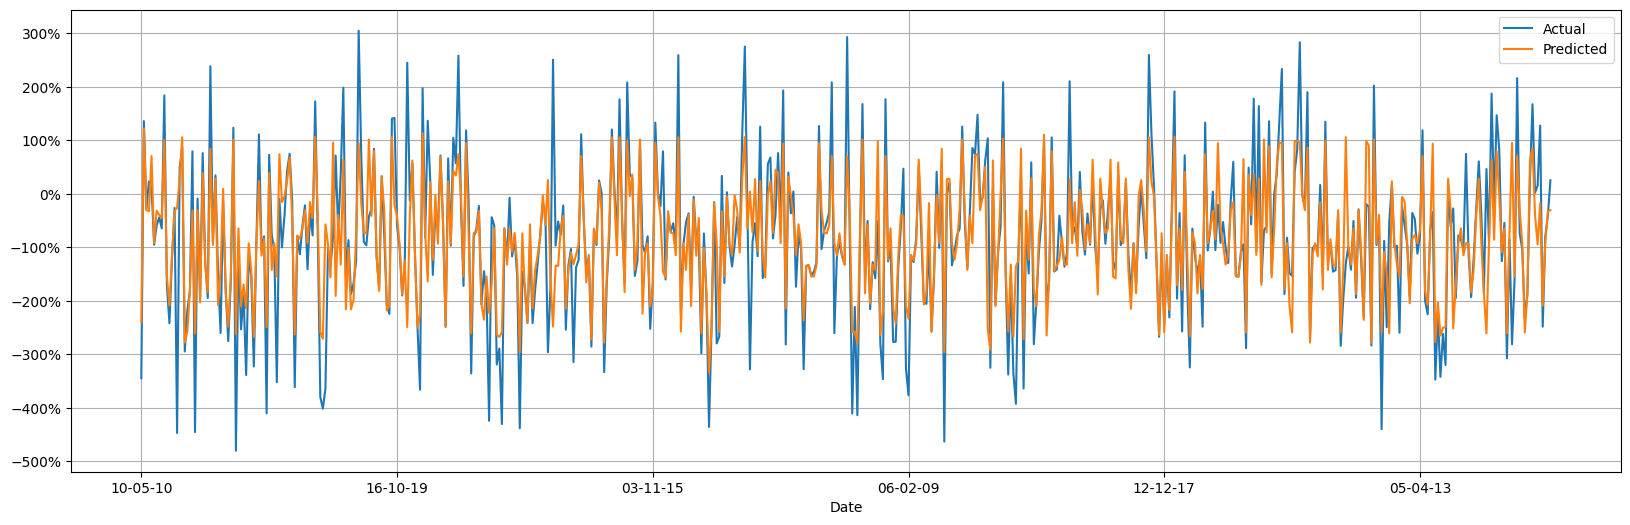

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_10376\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_50_1d_return', ylabel='Density'>

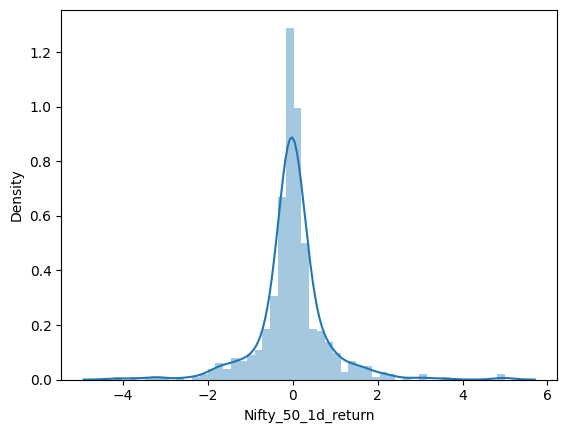

In [18]:
sns.distplot(y_test-y_pred)

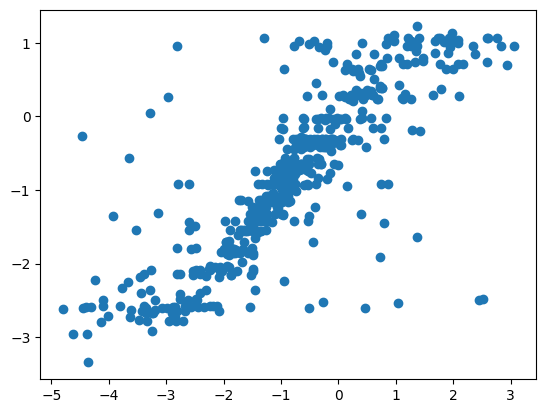

In [19]:
plt.scatter(y_test,y_pred)